In [3]:
import numpy as np
from datetime import datetime
import cv2
import os
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms, models
from dataset import Asbest_segmentation
from tqdm import tqdm
import matplotlib.pyplot as plt
import rawpy
import segmentation_models_pytorch as smp
from utils import parse_anno_file, create_mask_file, big_image_predict, get_time, true_results
# from apex import amp

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
def calculate_info(img_pathes, model, thresh=0.5):
    results = []
    size = 1024
    for obj in img_pathes:
        img = cv2.imread(obj, cv2.IMREAD_UNCHANGED)
        img, st, asb = big_image_predict(model, 
                                         img,
                                         crop_size=(size, size),
                                         inp_size=(size, size),
                                         device=device
                                        )
        results.append(len(np.where(asb > thresh)[0]) / img.shape[0] / img.shape[1])
    return results

In [5]:
dist_norm = lambda x : np.exp(- x ** 2 / 2) / (2 * np.pi) ** (1/2) 

def pz_approx(a, h, kernel, nums):
    t = np.linspace(min(a), max(a), nums)
    f = np.zeros(t.shape)
    for i in range(len(t)):
        for j in range(len(a)):
            f[i] += 1 / (len(a) * h) * np.sum(kernel((t[i] - a[j]) / h))
    return f

def get_quartiles(x, a):
    y = np.cumsum(a) / np.sum(a)
    indexes = np.argsort(abs(y - 0.05))[:2]
    q5 = x[indexes][0]
    indexes = np.argsort(abs(y - 0.5))[:2]
    q50 = x[indexes][0]
    indexes = np.argsort(abs(y - 0.95))[:2]
    q95 = x[indexes][0]
    return q5, q50, q95

def get_h(dist, h=0.01):
    direction = 1e-4
    a = np.array(dist)
    f = -np.Inf
    flag = True
    while abs(direction) >= 1e-5: 
        l = []
        h += direction
        if h <= 0:
            print('!')
            break 
        for i in range(len(a)):
            l.append(np.log(np.sum([dist_norm((a[i] - a[j]) / h) for j in range(len(a)) if i != j]) / (len(a) - 1) / h))
        r = np.sum(l) / len(a)              
        if r < f:
            h -= direction
            if flag:
                direction = -direction
                flag = False
            else:
                direction = direction * 1e-1
        else:
            f = r
    return h


def get_pz_quantils(dist, h, num_points = 200):
    a = np.array(dist)
    t = np.linspace(np.min(a), np.max(a), num_points)
    f = pz_approx(a, h, dist_norm, num_points)
    q5, q50, q95 = get_quartiles(t, f)
    return q5, q50, q95


def plot_dist_pz(dist, h, num_points = 200):
    a = np.array(dist)
    hist, x, *_ = np.histogram(a, bins=10);
    hist = hist / sum(hist) / (x[1] - x[0])
    plt.bar([(x[i] + x[i+1]) / 2 for i in range(len(x) - 1)], hist, width=(x[1] - x[0]))
    t = np.linspace(np.min(a), np.max(a), num_points)
    f = pz_approx(a, h, dist_norm, num_points)
    q5, q50, q95 = get_quartiles(t, f)
    plt.plot(t, f, 'r')
    plt.xlabel('Удельное содержание асбеста')
    plt.vlines(np.array([q5, q50, q95]), 0, max(hist))
    print('Квантиль на уровне доверительной вероятности 0.05 = ', q5)
    print('Квантиль на уровне доверительной вероятности 0.50 = ', q50)
    print('Квантиль на уровне доверительной вероятности 0.95 = ', q95)
    return q5, q50, q95

In [6]:
path = 'asbestos/stones'

data = {
    '020221' : 
    { 1 : { 
        'content' : 0.030,
        'n' : 5, 
        'sort_images' : {},
        'res' : {},
        'images' : [
        'asbestos/stones/020221/ManualDetailedImage_12_04_45f_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_05_01_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_06_30f_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_07_14_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_08_07f_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_08_29_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_09_38f_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_09_52_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_11_17f_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_11_32_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_13_48f_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_14_01_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_15_13f_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_15_45_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_17_26f_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_17_46_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_19_00f_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_19_17_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_23_52f_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_24_11_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_25_15f_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_25_24_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_27_03f_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_27_48_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_31_20f_300.bmp', 
        'asbestos/stones/020221/ManualDetailedImage_12_32_00_300.bmp'],
     },
     2 : { 
         'content' : 0.015,
         'n' : 6, 
         'sort_images' : {},
         'res' : {},
         'images' :[
         'asbestos/stones/020221/ManualDetailedImage_12_47_38f_150.bmp', 
         'asbestos/stones/020221/ManualDetailedImage_12_49_13_150.bmp', 
         'asbestos/stones/020221/ManualDetailedImage_12_51_54f_150.bmp', 
         'asbestos/stones/020221/ManualDetailedImage_12_52_28_150.bmp', 
         'asbestos/stones/020221/ManualDetailedImage_12_55_14f_150.bmp', 
         'asbestos/stones/020221/ManualDetailedImage_12_55_48_150.bmp', 
         'asbestos/stones/020221/ManualDetailedImage_12_58_06f_150.bmp', 
         'asbestos/stones/020221/ManualDetailedImage_12_58_51_150.bmp'
     ]
     }
    },
    '161220': 
     { 2: { 
         'content' : 0.02,
         'n' : 2,
         'sort_images' : {},
         'res' : {},
         'images' :
      [
         'asbestos/stones/161220/ManualDetailedImage_10_01_52.bmp', 
         'asbestos/stones/161220/ManualDetailedImage_10_03_00.bmp', 
         'asbestos/stones/161220/ManualDetailedImage_10_03_35.bmp', 
         'asbestos/stones/161220/ManualDetailedImage_10_04_15.bmp', 
         'asbestos/stones/161220/ManualDetailedImage_10_05_20.bmp', 
         'asbestos/stones/161220/ManualDetailedImage_10_05_58.bmp', 
         'asbestos/stones/161220/ManualDetailedImage_10_06_46.bmp', 
         'asbestos/stones/161220/ManualDetailedImage_10_07_31.bmp', 
         'asbestos/stones/161220/ManualDetailedImage_10_10_10.bmp',
         'asbestos/stones/161220/ManualGeneralImage_10_01_26.bmp'
      ]
      },
      3: { 'content' : 0.02,
          'n' : 3,
          'sort_images' : {},
          'res' : {},
         'images' :
      [
         'asbestos/stones/161220/ManualDetailedImage_10_26_43.bmp', 
         'asbestos/stones/161220/ManualDetailedImage_10_27_18.bmp', 
         'asbestos/stones/161220/ManualDetailedImage_10_27_30.bmp', 
         'asbestos/stones/161220/ManualDetailedImage_10_27_58.bmp', 
         'asbestos/stones/161220/ManualDetailedImage_10_29_22.bmp',
     ],
         },
      4: { 'content' : 0.04,
          'n' : 4,
          'sort_images' : {},
          'res' : {},
         'images' :[
          'asbestos/stones/161220/ManualDetailedImage_11_03_34.bmp', 
          'asbestos/stones/161220/ManualDetailedImage_11_04_07.bmp', 
          'asbestos/stones/161220/ManualDetailedImage_11_05_06.bmp', 
          'asbestos/stones/161220/ManualDetailedImage_11_05_43.bmp', 
          'asbestos/stones/161220/ManualDetailedImage_11_06_02.bmp', 
          'asbestos/stones/161220/ManualDetailedImage_11_06_30.bmp', 
          'asbestos/stones/161220/ManualDetailedImage_11_07_12.bmp', 
          'asbestos/stones/161220/ManualDetailedImage_11_07_55.bmp', 
          'asbestos/stones/161220/ManualDetailedImage_11_08_37.bmp', 
          'asbestos/stones/161220/ManualDetailedImage_11_09_00.bmp', 
          'asbestos/stones/161220/ManualDetailedImage_11_09_20.bmp', 
          'asbestos/stones/161220/ManualDetailedImage_11_09_58.bmp'
      ],
         },
      1: 
      {'content' : 0.02,
       'n' : 1,
       'sort_images' : {},
       'res' : {},
         'images' : [
          'asbestos/stones/161220/ManualGeneralImage_09_27_13.bmp', 
          'asbestos/stones/161220/ManualGeneralImage_09_30_19.bmp', 
          'asbestos/stones/161220/ManualGeneralImage_09_31_25.bmp', 
          'asbestos/stones/161220/ManualGeneralImage_09_32_23.bmp', 
          'asbestos/stones/161220/ManualGeneralImage_09_35_25.bmp', 
          'asbestos/stones/161220/ManualGeneralImage_09_35_52.bmp', 
          'asbestos/stones/161220/ManualGeneralImage_09_36_12.bmp', 
          'asbestos/stones/161220/ManualGeneralImage_09_36_44.bmp']
      }
     },
    '230321' : 
    { 1 : 
     { 
         'content' : 0.025,
         'n' : 7,
         'sort_images' : {},
         'res' : {},
         'images' : {
             0 : [
#                  'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-15-18_1_1_detailed.bmp',
#                  'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-15-29_2_1_detailed.bmp',
#                  'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-15-37_3_1_detailed.bmp',
#                  'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-15-46_4_1_detailed.bmp',
#                  'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-15-51_5_1_detailed.bmp',
#                  'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-16-24_8_1_detailed.bmp',
#                  'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-16-37_9_1_detailed.bmp',
#                  'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-16-48_10_1_detailed.bmp',
#                  'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-17-04_11_1_detailed.bmp',
#              'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-17-49_14_1_detailed.bmp',
#              'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-18-01_15_1_detailed.bmp',
#              'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-19-36_22_1_detailed.bmp',
#              'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-19-51_23_1_detailed.bmp',
#              'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-20-42_28_1_detailed.bmp',
#              'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-21-05_30_1_detailed.bmp',
         ],
             1 : [
#                  'asbestos/stones/230321/1/AutoScan_11_38_51/23-03-2021-11-39-39_1_1_detailed.bmp',
#                  'asbestos/stones/230321/1/AutoScan_11_38_51/23-03-2021-11-39-55_2_1_detailed.bmp',
#                  'asbestos/stones/230321/1/AutoScan_11_38_51/23-03-2021-11-40-01_3_1_detailed.bmp',
#                  'asbestos/stones/230321/1/AutoScan_11_38_51/23-03-2021-11-40-09_4_1_detailed.bmp',
#                  'asbestos/stones/230321/1/AutoScan_11_38_51/23-03-2021-11-40-19_5_1_detailed.bmp',
#                  'asbestos/stones/230321/1/AutoScan_11_38_51/23-03-2021-11-40-29_6_1_detailed.bmp',
#                  'asbestos/stones/230321/1/AutoScan_11_38_51/23-03-2021-11-40-35_7_1_detailed.bmp',
#                  'asbestos/stones/230321/1/AutoScan_11_38_51/23-03-2021-11-40-47_8_1_detailed.bmp',
#                  'asbestos/stones/230321/1/AutoScan_11_38_51/23-03-2021-11-40-55_9_1_detailed.bmp',
#                  'asbestos/stones/230321/1/AutoScan_11_38_51/23-03-2021-11-41-11_10_1_detailed.bmp',
             ]
                    },
     },
     2 : 
     { 
         'content' : 0.035,
         'n' : 8,
         'sort_images' : {},
         'res' : {},
         'images' : {},
     },
     3 : 
     { 
         'content' : 0.025,
         'n' : 9,
         'sort_images' : {},
         'res' : {},
         'images' : {},
     }
    },
    '200421' : 
    {
        1 : 
        {
            'content' : 0.04,
             'n' : 10,
             'sort_images' : {},
             'res' : {},
             'images' : {},
        },
        2 : 
        {
            'content' : 0.025,
             'n' : 11,
             'sort_images' : {},
             'res' : {},
             'images' : {},
        },
        3 : 
        {
            'content' : 0.015,
             'n' : 12,
             'sort_images' : {},
             'res' : {},
             'images' : {},
        },
    }
}

In [7]:
for pit in os.listdir(os.path.join(path, '230321')):
    for i, case in enumerate(os.listdir(os.path.join(path, '230321', pit))):
        data['230321'][int(pit)]['images'][i] =  sorted([os.path.join(path, '230321', pit, case, file) for file in os.listdir(os.path.join(path, '230321', pit, case)) if file.endswith('detailed.bmp')])
        
for pit in os.listdir(os.path.join(path, '200421')):
    for i, case in enumerate(os.listdir(os.path.join(path, '200421', pit))):
        data['200421'][int(pit)]['images'][i] =  sorted([os.path.join(path, '200421', pit, case, 'Detailed', file) for file in os.listdir(os.path.join(path, '200421', pit, case, 'Detailed')) if file.endswith('detailed.bmp')])

In [8]:
device = torch.device("cuda:" + str(torch.cuda.device_count() - 1) if torch.cuda.is_available() else "cpu")

model_asbest = smp.Unet(encoder_name='efficientnet-b3', in_channels=1, classes=2, activation='sigmoid').to(device)
model_asbest.load_state_dict(torch.load('asbest_segmentation_b3_v1.3a.pth'))
model_asbest.eval();

In [ ]:
results = {'content' : [], 'q5' : [], 'q50' : [], 'q95' : [], 'date' : [], 'num' : []}
for date in tqdm(data.keys(), total=len(data.keys())):
    for pit in data[date].keys():
        if type(data[date][pit]['images']) is list:
            res = calculate_info(data[date][pit]['images'], model_asbest)
            indexes = np.argsort(res)[::-1]
            data[date][pit]['sort_images'] = list(np.array(data[date][pit]['images'])[indexes])
            data[date][pit]['res'] = list(np.array(res)[indexes])
#             h = get_h(res)
#             q5, q50, q95 = get_pz_quantils(res, h)
#             content = data[date][pit]['content']
#             results['content'].append(content)
#             results['q5'].append(q5)
#             results['q50'].append(q50)
#             results['q95'].append(q95)
#             results['date'].append(date)
#             results['num'].append(data[date][pit]['n'])
        elif type(data[date][pit]['images']) is dict:
            for ind in data[date][pit]['images'].keys():
                res = calculate_info(np.array(data[date][pit]['images'][ind]), model_asbest, thresh=0.5)
                indexes = np.argsort(res)[::-1]
                data[date][pit]['sort_images'][ind] = list(np.array(data[date][pit]['images'][ind])[indexes])
                data[date][pit]['res'][ind] = list(np.array(res)[indexes])
#                 h = get_h(res)
#                 q5, q50, q95 = get_pz_quantils(res, h)
#                 content = data[date][pit]['content']
#                 results['content'].append(content)
#                 results['q5'].append(q5)
#                 results['q50'].append(q50)
#                 results['q95'].append(q95)
#                 results['date'].append(date)
#                 results['num'].append(data[date][pit]['n'])

 75%|█████████████████████████████████████████████████▌                | 3/4 [07:11<02:57, 177.76s/it]

In [11]:
for date in data.keys():
    for pit in data[date].keys():
        if type(data[date][pit]['images']) is list:
            print(date, pit, len(data[date][pit]['images']))
        elif type(data[date][pit]['images']) is dict:
            for ind in data[date][pit]['images'].keys():
                print(date, pit, len(data[date][pit]['images'][ind]))

020221 1 26
020221 2 8
161220 2 10
161220 3 5
161220 4 12
161220 1 8
230321 1 49
230321 1 40
230321 2 35
230321 2 45
230321 3 49
200421 1 45
200421 1 39
200421 1 58
200421 2 28
200421 2 39
200421 2 44
200421 3 63


In [12]:
num_images = 100
results = {'content' : [], 'q5' : [], 'q50' : [], 'q95' : [], 'date' : [], 'num' : []}
for date in tqdm(data.keys(), total=len(data.keys())):
    for pit in data[date].keys():
        if type(data[date][pit]['images']) is list:
            h = get_h(np.array(data[date][pit]['res']))
            q5, q50, q95 = get_pz_quantils(data[date][pit]['res'][:num_images], h)
            content = data[date][pit]['content']
            results['content'].append(content)
            results['q5'].append(q5)
            results['q50'].append(q50)
            results['q95'].append(q95)
            results['date'].append(date)
            results['num'].append(data[date][pit]['n'])
        elif type(data[date][pit]['images']) is dict:
            for ind in data[date][pit]['images'].keys():
                h = get_h(np.array(data[date][pit]['res'][ind]))
                q5, q50, q95 = get_pz_quantils(data[date][pit]['res'][ind][:num_images], h)
                content = data[date][pit]['content']
                results['content'].append(content)
                results['q5'].append(q5)
                results['q50'].append(q50)
                results['q95'].append(q95)
                results['date'].append(date)
                results['num'].append(data[date][pit]['n'])

100%|███████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.33s/it]


[-0.20255358  3.07992831]


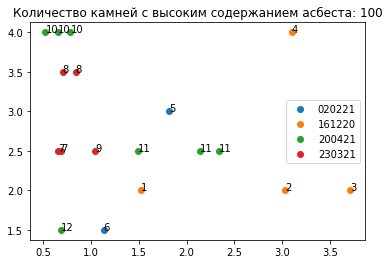

In [13]:
for date in np.unique(results['date']):
    indexes = np.array(results['date']) == date
    plt.scatter(100*np.array(results['q50'])[indexes], 100*np.array(results['content'])[indexes], label=date)
plt.legend()

for i, (y, x) in enumerate(zip(results['content'], results['q50'])):
    plt.text(100*x, 100*y, results['num'][i])

t = [100*min(results['q50']), 100*max(results['q50'])]
p = np.polyfit(100*np.array(results['q50']), 100*np.array(results['content']), 1)
y = np.polyval(p, t)
print(p)
        
plt.title('Количество камней с высоким содержанием асбеста: ' + str(num_images))
plt.savefig('graphics/results_' + str(num_images) + '.png', dpi=300, bbox_inches='tight', pad_inches=0)

In [ ]:
100*np.array(results['q50'])

array([1.77802493, 1.15987689, 2.93684594, 3.64560652, 3.03982824,
       1.55562782, 0.73262767, 0.66877723, 0.72009065, 0.86288438,
       1.0525592 , 0.59951866, 0.74061603, 0.49531322, 1.75171684,
       2.18692195, 2.4581593 , 0.66172358])

In [42]:
100*np.array(results['q50'])

In [54]:
# import pandas as pd

# d = {
#     'Забой' : results['num'],
#     '512' : it_was,
#     '704' : 100*np.array(results['q50']),
#     '1024' : it_was_1024,
#     'разница' : 100 * np.array(results['q50']) - it_was_1024,
#     'изменение в %' : 100*(100*np.array(results['q50']) - it_was_1024) / (100*np.array(results['q50'])),
# }
# df = pd.DataFrame(d)
# df

,Забой,512,704,1024,разница,изменение в %
0,5,1.858194,1.778025,1.818567,-0.040542,-2.280195
1,6,1.242866,1.159877,1.129635,0.030242,2.607347
2,2,2.972204,2.936846,3.026978,-0.090132,-3.069017
3,3,3.709977,3.645607,3.707007,-0.061400,-1.684232
4,4,3.041230,3.039828,3.101333,-0.061505,-2.023307
5,1,1.610476,1.555628,1.521944,0.033683,2.165267
6,7,0.818722,0.732628,0.687647,0.044981,6.139669
7,7,0.745980,0.668777,0.658319,0.010458,1.563712
8,8,0.808932,0.720091,0.702228,0.017863,2.480670
9,8,0.957879,0.862884,0.840049,0.022835,2.646388


In [56]:
np.mean(100*(100*np.array(results['q50']) - it_was_1024) / (100*np.array(results['q50'])))

0.4500436363883217